In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

# 앙상블과 랜덤 포레스트
* **앙상블(Ensemble)** : 일련의 예측기
* **앙상블 학습(Ensemble Learning)/앙상블 방법(Ensemble method)** : 일련의 예측기(즉, 분류나 회귀 모델)로부터 예측을 수집하면 가장 좋은 모델 하나보다 더 좋은 예측을 얻을 수 있다. 이러한 방법
* ex)  
훈련 세트로부터 무작위로 각기 다른 subset을 만들어 일련의 결정 트리 분류기를 훈련시킬 수 있다. 예측을 하려면 모든 개별 트리의 예측을 구하면 된다. 그런 다음 가장 많은 선택을 받은 클래스를 예측으로 삼는다.
* **랜덤 포레스트(Random Forest)** : 결정 트리의 앙상블

# 1. 투표 기반 분류기
* 더 좋은 분류기를 만드는 매우 간단한 방법 : 각 분류기(로지스틱 회귀 분류기, SVM 분류기, 랜덤포레스트 분류기, K-최근접 이웃 분류기 등)의 예측을 모아서 가장 많이 선택된 클래스를 예측하는 것

## 1.1. 직접 투표(hard voting) 분류기
* 이렇게 다수결 투표로 정해지는 분류기
* 다수결 투표 분류기가 앙상블에 포함된 개별 분류기 중 가장 뛰어난 것보다도 정확도가 높은 경우가 많다.
* 각 분류기가 **약한 학습기(weak learner)**(즉, 랜덤 추측보다 조금 더 높은 성능을 내는 분류기)일지라도 충분하게 많고 다양하다면 앙상블은 (높은 정확도를 내는) **강한 학습기(strong learner)**가 될 수 있다.

### 1.1.1. 앙상블이 강한 학습기가 될 수 있는 이유
#### 예) 동전을 던졌을 때 앞면이 51%, 뒷면이 49% 나오는 조금 균형이 맞지 않는 동전
* 이 동전을 1,000번 던진다면 대략 510번 앞면, 490번 뒷면이 나올 것이므로, 다수는 앞면이 된다.
* 수학적으로 계산하면 1,000번 던진 후 앞면이 다수가 될 확률 = 75%가 된다.
* **큰 수의 법칙(law of large numbers)** 때문에 더 많이 던질수록 앞면이 다수일 확률은 증가한다. (예로 10,000번 던지면 확률이 97% 이상으로 올라간다).
> 이 확률은 이항 분포의 확률질량함수로 계산할 수 있다.  
확률이 $p$인 이항 분포에서 $n$번 시도 중 $k$번 성공할 확률은 $\frac{n}{k}p^k(1-p)^{(n-k)}$이다.  
성공 확률이 51%인 동전을 1,000번 던져서 앞면이 한번만 나올 확률은 $\frac{1000}{1}0.51^1(1-0.51)^{(1000-1)} = 1.6×10^{-307}$이 된다.  
이런 식으로 1,000의 과반 직전인 499까지의 확률을 더하여 전체 확률 1에서 빼면 1,000번 던져 앞면이 절반 이상 나올 확률이 된다.  
scipy에는 이항 분포의 누적분포함수가 있어 `1 - scipy.stats.binom.cdf(499, 1000, 0.51) = 0.747`로 손쉽게 구할 수 있다.   
또한 10,000번을 던져서 앞면이 절반 이상 나올 확률은 `1 - scipy.stats.binom.cdf(4999, 10000, 0.51) = 0.978)`이다.  
* 더 많이 던질수록 앞면이 나오는 비율은 점점 더 앞면이 나올 확률(51%)에 가까워 진다.

#### 균형이 틀어진 동전을 10번 실험한 그래프

In [14]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / \
        np.arange(1, 10001).reshape(-1, 1)

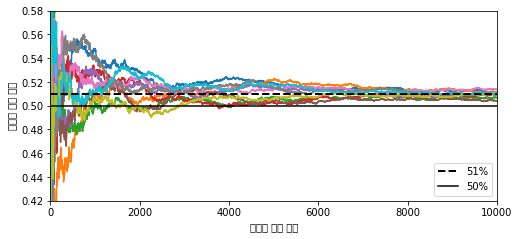

In [15]:
plt.figure(figsize=(8, 3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], 'k--', linewidth=2, label='51%')
plt.plot([0, 10000], [0.5, 0.5], 'k-', label='50%')
plt.xlabel('동전을 던진 횟수')
plt.ylabel('앞면이 나온 비율')
plt.legend(loc='lower right')
plt.axis([0, 10000, 0.42, 0.58])
plt.show()

> 던진 횟수가 증가할수록 앞면이 나올 확률이 51%에 가까워진다.  
결국 10번의 실험 모두 50%보다 높게 유지되며 51%에 수렴하면서 끝나고 있다.

#### 이와 비슷하게 (무작위 추측보다 조금 더 나은) 51% 정확도를 가진 1,000개의 분류기를 앙상블 모델로 구축한다고 가정
* 가장 많은 클래스를 예측으로 삼는다면 75%의 정확도를 기대할 수 있다.
* 하지만 이런 가정은 모든 분류기가 완벽하게 독립적이고, 오차에 상관관계가 없어야 가능하다.  
* 여기서는 같은 데이터로 훈련시키기 때문에 이런 가정이 맞지 않는다.  
* 분류기들이 같은 종류의 오차를 만들기 쉽기 때문에 잘못된 클래스가 다수인 경우가 많고 앙상블의 정확도가 낮아진다.

> **TIP**  
* 앙상블 방법은 예측기가 가능한 한 서로 독립적일 때 최고의 성능을 발휘한다.  
* **다양한 분류기를 얻는 한가지 방법** : 각기 다른 알고리즘으로 학습시키는 것
    * 이렇게 하면 매우 다른 종류의 오차를 만들 가능성이 높기 때문에 앙상블 모델의 정확도를 향상시킨다.
    
#### 여러 분류기를 조합하여 투표 기반 분류기(VotingClassifier)를 만들고 훈련시키기

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# scikit-learn 0.22에서 solver 기본값이 'liblinear'에서 'lbfgs'로 변경
# 책 결과와 맞추기 위해 명시적으로 'liblinear'로 설정
log_clf = LogisticRegression(solver='liblinear', random_state=42)

# 0.22에서 n_estimators 기본값이 100으로 변경
# 경고를 피하기 위해 현재 기본값인 10으로 설정
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)

# 0.22에서 gamma 기본값이 스케일 조정되지 않은 특성을 위해 'scale'로 변경
# 기존 방식 사용하고 경고를 없애기 위해 'auto'로 설정
svm_clf = SVC(gamma='auto', random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', Rando...f',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

#### 각 분류기의 테스트셋 정확도 확인

In [20]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


> 투표 기반 분류기가 다른 개별 분류기보다 성능이 조금 더 높다.

## 1.2. 간접 투표(soft voting)
* 모든 분류기가 클래스의 확률을 예측할 수 있다면(즉, `predict_proba()` 메서드가 있으면) 개별 분류기의 예측을 평균 내어 확률이 가장 높은 클래스를 예측할 수 있다. 이를 **간접 투표(soft voting)**라고 한다.
* 이 방식은 확률이 높은 투표에 비중을 더 두기 때문에 직접 투표 방식보다 성능이 높다.
* 이 방식을 사용하기 위해서는 `voing="soft"`로 바꾸고, 모든 분류기가 클래스의 확률을 추정할 수 있으면 된다.
    * `SVC`는 기본값에서 클래스 확률을 제공하지 않으므로 `probability=True`로 지정  
    (이렇게 하면 클래스 확률을 추정하기 위해 교차 검증을 사용하므로 훈련 속도가 느려지지만 `SVC`에서 `predict_proba()`를 사용할 수 있다.

In [21]:
log_clf = LogisticRegression(solver='liblinear', random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma='auto', probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', Rando...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

In [22]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


> 91%의 정확도를 보여준다.

# 2. 배깅과 페이스팅
* 다양한 분류기를 만드는 방법
    1. 각기 다른 훈련 알고리즘을 사용하는 것 (앞서 논의)
    2. 같은 알고리즘을 사용하지만 훈련 세트의 서브셋을 무작위로 구성하여 분류기를 각기 다르게 학습시키는 것
* **배깅(bagging (bootstrap aggregating))** : 훈련 세트에서 중복을 허용하여 샘플링하는 방식
> **부트스트래핑(bootstrapping)**  
통계학에서는 중복을 허용한 리샘플링(resampling)을 부트스프래핑이라고 한다.
* **페이스팅(pasting)** : 중복을 허용하지 않고 샘플링하는 방식

배깅과 페이스팅에서는 같은 훈련 샘플을 여러 개의 예측기에 걸쳐 사용할 수 있다.  
하지만 배깅만이 한 예측기를 위해 같은 훈련 샘플을 여러 번 샘플링할 수 있다.

#### 이 샘플링과 훈련 과정
* 모든 예측기가 훈련을 마치면 앙상블은 모든 예측기의 예측을 모아서 새로운 샘플에 대한 예측을 만든다.
* 수집 함수는 전형적으로 아래와 같은 값을 사용한다.
    * 분류일 때는 **통계적 최빈값(statistical mode)**(즉, 직접 투표 분류기처럼 가장 많은 예측 결과)
    * 회귀일 때는 평균을 계산
* 개별 예측기는 원본 훈련 세트로 훈련시킨 것보다 훨씬 크게 편향되어 있지만 수집 함수를 통과하면 편향과 분산이 모두 감소한다.
* 일반적으로 앙상블의 결과는 원본 데이터셋으로 하나의 예측기를 훈련시킬 때와 비교해 편향은 비슷하지만 분산은 줄어든다.
* 예측기는 모두 동시에 다른 CPU 코어나 서버에서 병렬로 학습과 예측을 시킬 수 있다.  
이런 확장성 덕분에 배깅과 페이스팅의 인기가 높다.

## 2.1. 사이킷런의 배깅과 페이스팅
* 사이킷런은 배깅과 페이스팅을 위해 간편한 API로 구성된 `BaggingClassifier`, `BaggingRegressor`를 제공한다.

#### 결정 트리 분류기 500개의 앙상블을 훈련시키기(배깅 앙상블)
> `max_samples`는 0.0 ~ 1.0 사이의 실수로 지정할 수도 있다. 이렇게 지정하면 샘플링되는 데이터 수는 "훈련 세트의 크기 × `max_samples`" 값이 된다.

* 각 분류기는 훈련 세트에서 중복을 허용하여 무작위로 선택된 100개의 샘플로 훈련된다. (페이스팅을 사용하려면 `bootstrap=False`로 지정)
* `n_job` : 훈련과 예측에 사용한 CPU 코어 수 지정 
    * `-1`:  가용한 모든 코어 사용 (default는 `1`)

In [25]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500, max_samples=100,
    bootstrap=True, n_jobs=-1, random_state=42
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [26]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_pred))

0.904


In [27]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


> `BaggingClassifier`는 기반이 되는 분류기가 결정 트리 분류기처럼 클래스 확률을 추정할 수 있으면(즉, `predict_proba()` 함수가 있으면) 직접 투표 대신 자동으로 간접 투표 방식을 사용한다.

#### 단일 결정 트리와 500개 트리로 만든 배깅 앙상블 비교

In [29]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, 
                          contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58', '#4c4c7f', '#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], 'yo', alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], 'bs', alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r'$x_1$', fontsize=18)
    plt.ylabel(r'$x_2$', fontsize=18, rotation=0)

C:\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1238: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


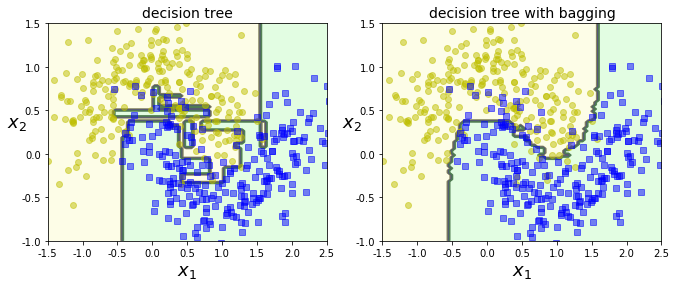

In [31]:
plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("decision tree", fontsize=14)

plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title('decision tree with bagging', fontsize=14)
plt.show()

> * **단일 결정 트리의 결정경계 (왼쪽)**  
* **500개 트리를 사용한 배깅 앙상블의 결정경계 (오른쪽)**
    * 결정 트리 하나의 예측보다 일반화가 훨씬 잘된 것 같다.

* 앙상블은 비슷한 편향에서 더 작은 분산을 만든다. (훈련 세트의 오차 수가 거의 비슷하지만 결정 경계는 덜 불규칙하다)
* 부트스트래핑은 각 예측기가 학습하는 서브셋에 다양성을 증가시키므로 배깅이 페이스팅보다 편향이 조금 더 높다.
* 하지만 이는 예측기들의 상관관계를 줄이므로 앙상블의 분산을 감소시킨다.
* 전반적으로 배깅이 더 나은 모델을 만들기 때문에 더 선호하지만 시간과 CPU 파워에 여유가 있다면 교차 검증으로 배깅과 페이스팅을 모두 평가해서 더 나은 쪽을 선택하는 것이 좋다.

## 2.2. oob 평가
### 2.2.1. oob
* 배깅을 사용하면 어떤 샘플은 한 예측기를 위해 여러 번 샘플링되고 어떤 것은 전혀 선택되지 않을 수 있다. 
* `BaggingClassifier`는 기본값으로 중복을 허용하여(`bootstrap=True`) 훈련 세트의 크기만큼인 $m$개 샘플을 선택한다. 이는 평균적으로 각 예측기에 훈련 샘플의 63% 정도만 샘플링된다는 것을 의미한다.
> $m$이 커지면 이 비율이 $1 - ex(-1) ≒ 63.212%$에 가까워진다.  
$m$개의 샘플에서 무작위로 하나를 추출할 때 선택되지 않을 확률은 $1 - \frac{1}{m}$이고, 이를 $m$번 반복했을 때도 선택되지 않을 확률은 $(1 - \frac{1}{m})^m$이다.  
여기에 $log$를 취하고 로피탈 정리를 적용하면 이 값이 $e^{-1}$과 같아진다. 따라서 샘플링될 확률은 $1 - e^{-1} = 0.63212$가 된다.
* 선택되지 않은 훈련 샘플의 나머지 37%를 **oob(out-of-bag) 샘플**이라고 부른다. 예측기마다 남겨진 37%는 모두 다르다.

### 2.2.2. oob 평가
* 예측기가 훈련되는 동안에는 oob 샘플을 사용하지 않으므로 검증 세트나 교차 검증을 사용하지 않고 oob 샘플을 사용해 평가할 수 있다.
* 앙상블의 평가는 각 예측기의 oob 평가를 평균하여 얻는다.
* `BaggingClassifier`의 `oob_score=True`로 지정하면 훈련이 끝난 후 자동으로 oob 평가를 수행한다.
* 평가 점수 결과는 `oob_score_` 변수에 저장되어 있다.

In [39]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500, bootstrap=True, n_jobs=-1,
    oob_score=True)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9013333333333333

> oob 평가 결과를 보면 이 `BaggingClassifier`는 테스트 세트에서 약 90.1%의 정확도를 얻을 것으로 보인다.

In [33]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

> 테스트 세트에서 91.2% 정확도를 얻어 매우 비슷하다.

#### oob 샘플에 대한 결정 함수의 값 확인
* oob 샘플에 대한 결정 함수 값도 `oob_decision_function_` 변수에서 확인할 수 있다.
* 이 경우 결정 함수는 각 훈련 샘플의 클래스 확률을 반환한다(기반이 되는 예측기가 `predict_proba()` 메서드를 가지고 있기 때문에)

In [53]:
bag_clf.oob_decision_function_

array([[0.44444444, 0.55555556],
       [0.32835821, 0.67164179],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.03867403, 0.96132597],
       [0.34104046, 0.65895954],
       [0.01111111, 0.98888889],
       [0.97883598, 0.02116402],
       [0.97814208, 0.02185792],
       [0.75706215, 0.24293785],
       [0.00531915, 0.99468085],
       [0.76162791, 0.23837209],
       [0.82795699, 0.17204301],
       [0.96907216, 0.03092784],
       [0.05847953, 0.94152047],
       [0.        , 1.        ],
       [0.97252747, 0.02747253],
       [0.97395833, 0.02604167],
       [0.99492386, 0.00507614],
       [0.03278689, 0.96721311],
       [0.36170213, 0.63829787],
       [0.95192308, 0.04807692],
       [1.        , 0.        ],
       [0.97382199, 0.02617801],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.57386364, 0.42613636],
       [0.

> oob 평가는 첫 번째 훈련 샘플이 양성 클래스에 속할 확률을 55.55%로 추정하고 있다.  
음성 클래스에 속할 확률은 44.44%이다.

# 3. 랜덤 패치와 랜덤 서브스페이스

## 3.1. `BaggingClassifier`의 특성 샘플링
* `max_features`, `bootstrap_features` 매개변수 조절로 특성 샘플링이 가능하다.
    * 작동 방식은 동일하지만 샘플이 아니고 특성에 대한 샘플링이다.
* 따라서 각 예측기는 무작위로 선택한 입력 특성의 일부분으로 훈련된다.
* 특히 (이미지와 같은) 매우 고차원의 데이터셋을 다룰 때 유용하다.
* **랜덤 패치 방식(Random Pathces method)** : 훈련 특성과 샘플을 모두 샘플링하는 것
* **랜덤 서브스페이스 방식(Random Subspaces method)** : 훈련 샘플을 모두 사용하고(즉, `bootstrap=False`이고 `max_samples=1.0`) 특성은 샘플링하는(즉, `bootstrap_features=True`이고 `max_features`는 `1.0`보다 작은) 것
* 특성 샘플링은 더 다양한 예측기를 만들면 편향을 늘리는 대신 분산을 낮춘다.

# 4. 랜덤 포레스트
* 일반적으로 배깅 방법(또는 페이스팅)을 적용한 결정 트리의 앙상블
* 전형적으로 `max_samples`를 훈련 세트의 크기로 지정
* `BaggingClassifier`에 `DecisionTreeClassifier`를 넣어 만드는 대신 결정 트리에 최적화되어 사용하기 편리한 `RandomForestClassifier`를 사용할 수 있다. (회귀는 `RandomForestRegressor`)
> `BaggingClassifier`는 결정 트리 이외의 모델을 앙상블하고 싶을 때 여전히 유용하다.

#### (최대 16개 leaf node를 갖는) 500개 트리로 이뤄진 랜덤 포레스트 분류기를 여러 CPU 코어에서 훈련시키기

In [59]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

#### `BaggingClassifier`를 사용해 앞의 `RandomForestClasssfer`와 거의 유사하게 만들기

In [60]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter='random', max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [58]:
np.sum(y_pred == y_pred_rf) / len(y_pred) # 거의 동일한 예측

0.984

* `RandomForestClassifier`는 몇 가지 예외가 있지만 (트리 성장의 조절을 위한) `DecisionTreeClassifier`의 매개변수와 (앙상블 자체를 제어하는데 필요한) `BaggingClassifier`의 매개변수를 모두 가지고 있다.
> **몇 가지 예외항목**  
    * `DecisionTreeClassifier`의 매개변수
        * `splitter`(무조건 `"best"`)
        * `presort`(무조건 `False`)
    * `BaggingClassifier`의 매개변수
        * `max_samples`(무조건 `1.0`)
        * `base_estimator`(무조건 지정된 매개변수를 사용한 `DecisionTreeClassifier`)
        
* 랜덤 포레스트 알고리즘은 트리의 node를 분할할 때 전체 특성 중에서 최선의 특성을 찾는 대신 무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 식으로 무작위성을 더 주입한다.(6장 참조)
* 이는 결국 트리를 더욱 다양하게 만들고 (다시 한 번) 편향을 손해 보는 대신 분산을 낮추어 전체적으로 더 훌륭한 모델이 만들어진다.

## 4.1. 엑스트라 트리
* 트리를 더욱 무작위하게 만들기 위해 (보통의 결정 트리처럼) 각 node를 무작위로 특성의 subset으로 만들어 분할에 사용하기 위해 최적의 임곗값을 찾는 대신 후보 특성을 사용해 무작위로 분할한 다음 그 중에서 최상의 분할을 선택한다.
* 이와 같이 극단적으로 무작위한 트리의 랜덤 포레스트를 **익스트림 랜덤트리(Extremely Randomized Tree)** 앙상블(줄여서 **엑스트라 트리(Extra-Trees)**)이라고 부른다.
* 여기서도 역시 편향이 늘어나지만 대신 분산을 낮추게 된다.
* 모든 node에서 특성마다 가장 최적의 임곗값을 찾는 것이 트리 알고리즘에서 가장 시간이 많이 소요되는 작업 중 하나이므로, 일반적인 랜덤 포레스트보다 엑스트라 트리가 훨씬 빠르다.
* `ExtraTreesClassifier`를 사용하여 엑스트라 트리를 만든다.
    * 사용법은 `RandomForestClassifier`와 동일
    * `ExtraTreesRegressor`도 `RandomForestRegressor`와 같은 API 제공
    > 엑스트라 트리의 무작위 분할을 단일 결정 트리에 적용한 모델은 `ExtraTreeClassifier`와 `ExtraTreeRegressor`이다.
    
> **TIP**  
`RandomForestClassifier`가 `ExtraTreesClassifier`보다 더 나을지, 나쁠지 예단하긴 어렵다.  
일반적으로 둘 다 시도해보고 교차 검증으로 비교해보는 것이 유일한 방법이다.  
(그리고 그리드 탐색으로 하이퍼파라미터 튜닝을 한다.)

## 4.2. 특성 중요도
* 랜덤 포레스트의 또 다른 장점은 특성의 상대적 중요도를 측정하기 쉽다는 것
> 결정 트리 기반 모델은 모두 특성 중요도를 제공한다.  
    * `DecisionTreeClassifier`의 특성 중요도 : 일부 특성을 완전히 배제
    * 무작위성이 주입된 `RandomForestClassifier` : 거의 모든 특성에 대해 평가할 기회를 가진다.

* scikit-learn은 어떤 특성을 사용한 node가 (랜덤 포레스트에 있는 모든 트리에 걸쳐서) 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도를 측정한다.
* 더 정확히 말하면 가중치 평균이며, 각 node의 가중치는 연관된 훈련 샘플 수와 같다.(6장 참조)
> * **결정 트리의 특성 중요도**
    * 노드에 사용된 특성별로 (현재 노드의 샘플 비율 × 불순도) - (왼쪽 자식 노드의 샘플 비율 × 불순도) - (오른쪽 자식 노드의 샘플 비율 × 불순도)와 같이 계산하여 더하고, 특성 중요도의 합이 1이 되도록 전체 합으로 나누어 정규화한다.
        * 여기서 샘플 비율은 트리 전체 샘플 수에 대한 비율
 * **랜덤 포레스트의 특성 중요도**
    * 각 결정 트리의 특성 중요도를 모두 계산하여 더한 후 트리 수로 나눈 것
    
* scikit-learn은 훈련이 끝난 뒤 특성마다 자동으로 이 점수를 계산하고 중요도의 전체 합이 1이 되도록 결괏값을 정규화한다.
    * 이 값은 `feature_importances_` 변수에 저장되어 있다.
    
#### iris 데이터셋에 `RandomForestClassifier`를 훈련시키고 각 특성의 중요도 출력하기

In [68]:
from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(iris['data'], iris['target'])

for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876374
sepal width (cm) 0.023119288282510326
petal length (cm) 0.44103046436395765
petal width (cm) 0.4233579963547681


> 가장 중요한 특성은 꽃잎 길이(44%), 너비(42%)이고, 꽃받침 길이(11%)와 너비(2%)는 비교적 덜 중요해 보인다.

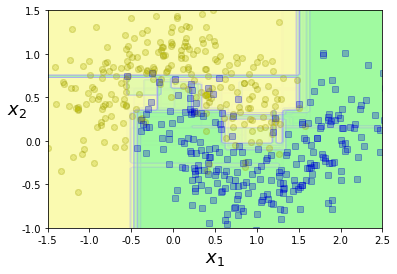

In [71]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.02,
                           contour=False)
    
plt.show()

#### oob 평가

In [72]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9013333333333333

In [74]:
bag_clf.oob_decision_function_

array([[0.31746032, 0.68253968],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.08379888, 0.91620112],
       [0.31693989, 0.68306011],
       [0.02923977, 0.97076023],
       [0.97687861, 0.02312139],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.71195652, 0.28804348],
       [0.83957219, 0.16042781],
       [0.97777778, 0.02222222],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97297297, 0.02702703],
       [0.95238095, 0.04761905],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.38947368, 0.61052632],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.96685083, 0.03314917],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.64804469, 0.35195531],
       [0.

In [76]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

#### MNIST 데이터셋에 랜덤 포레스트 분류기를 훈련시키고 각 픽셀의 중요도를 그래프로 나타내기

In [78]:
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original')
#from sklearn.datasets import fetch_openml

#mnist = fetch_openml('mnist_784', version=1, return_X_y=True)

C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


In [79]:
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
rnd_clf.fit(mnist['data'], mnist['target'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [82]:
import matplotlib as mpl

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=mpl.cm.hot, interpolation='nearest')
    plt.axis('off')

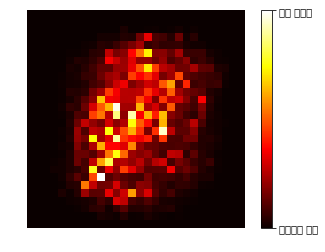

In [83]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), 
                           rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['중요하지 않음', '매우 중요함'])
plt.show()

> 어떤 픽셀이 중요한지 보여준다.

랜덤 포레스트는 특히 특성을 선택해야 할 때 어떤 특성이 중요한지 빠르게 확인할 수 있어 매우 편리하다.

# 5. 부스팅
* **부스팅**(boosting, 원래 가설 부스팅(hypothesis boosting)이라 부름) : 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법
* 부스팅 방법의 아이디어 : 앞의 모델을 보완해나가면서 일련의 예측기를 학습시키는 것
* 부스팅 방법
    * **아다부스트**(AdaBoost (Adaptive Boodsting의 줄임말))
    * **그래디언트 부스팅**(Gradient Boosting)

## 5.1. 아다부스트
* 아다부스트에서 사용하는 방식 : 이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높이는 것
    * 이렇게 하면 새로운 예측기는 학습하기 어려운 샘플에 점점 더 맞춰지게 된다.
* 예) 아다부스트 분류기 만들기
    1. 기반이 되는 첫 번째 분류기(예를 들면 결정 트리)를 훈련 세트에서 훈련시키고 예측을 만든다.
    2. 그 다음에 잘못 분류된 훈련 샘플의 가중치를 상대적으로 높인다.
    3. 두 번째 분류기는 업데이트된 가중치를 사용해 훈련 세트에서 훈련하고 다시 예측을 만든다.
    4. 그 다음에 다시 가중치를 업데이트하는 식으로 계속된다.
    
#### moons 데이터셋에서 훈련시킨 다섯 개의 연속된 예측기의 결정 경계
이 모델은 규제를 강하게 한 RBF 커널 SVM 분류기이다.
> 이는 예시용이며, 보통 SVM은 속도가 느리고 아다부스트와 함계 사용했을 때 불안정한 경향이 있어 아다부스트의 기반 예측기로는 적합하지 않다.

C:\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1238: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


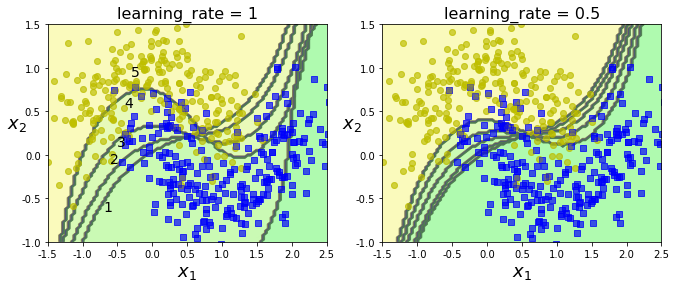

In [86]:
m = len(X_train)

plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    plt.subplot(subplot)
    if subplot == 121:
        plt.text(-0.7, -0.65, '1', fontsize=14)
        plt.text(-0.6, -0.10, '2', fontsize=14)
        plt.text(-0.5,  0.10, '3', fontsize=14)
        plt.text(-0.4,  0.55, '4', fontsize=14)
        plt.text(-0.3,  0.90, '5', fontsize=14)
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma='auto', random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
        
plt.show()

In [88]:
list(m for m in dir(ada_clf) if not m.startswith("_") and m.endswith("_"))

['base_estimator_',
 'classes_',
 'estimator_errors_',
 'estimator_weights_',
 'estimators_',
 'feature_importances_',
 'n_classes_']

> * 첫 번째 분류기
    * 많은 샘플을 잘못 분류해서 이 샘플들의 가중치가 높아졌다.
* 두 번째 분류기
    * 이 샘플들을 더 정확히 예측하게 된다.
* 오른쪽 그래프
    * 학습률을 반으로 낮춘 것만 빼고 똑같은 일련의 예측기를 나타낸 것 (즉, 잘못 분류된 샘플이 가중치는 반복마다 절반 정도만 높아진다)
    
> 이 그래프는 SVC 모델에서 `fit`메서드를 호출할 때 `sample_weight` 매개변수를 사용해 훈련 샘플의 가중치를 부여하여 만들었다.
* 왼쪽 그래프 : 잘못 분류된 샘플의 가중치를 2의 배수로 증가시킨 것
* 오른쪽 그래프 : 1.5배씩 증가시킨 것

    
* 그림에서 볼 수 있듯이 이런 연속된 학습 기법은 경사 하강법과 비슷한 면이 있다.
    * 경사 하강법은 비용 함수를 최소화하기 위해 한 예측기의 모델 파라미터를 조정해간다.
    * 반면 아다부스트는 점차 더 좋아지도록 앙상블에 예측기를 추가한다.
* 모든 예측기가 훈련을 마치면 이 앙상블은 배깅이나 페이스팅과 비슷한 방식으로 예측을 만든다.
* 하지만 가중치가 적용된 훈련 세트의 전반적인 정확도에 따라 예측기마다 다른 가중치가 적용된다.
> **CAUTION**  
연속된 학습 기법의 중요한 단점  
    * 각 예측기는 이전 예측기가 훈련되고 평가된 후에 학습될 수 있기 때문에 병렬화(또는 분할)를 할 수 없다.
    * 결국 배깅이나 페이스팅만큼 확장성이 높지 않다.

### 5.1.1. 아다부스트 알고리즘 자세히 보기
1. 각 샘플 가중치 $w_i$는 초기에 $\frac{1}{m}$로 초기화된다.  
첫 번째 예측기가 학습되고, 가중치가 적용된 에러율 $r_1$이 훈련 세트에 대해 계산된다.
#### j번째 예측기의 가중치가 적용된 에러율
$$ r_j = \frac{\sum_{i=1, \hat y_j^i≠y^i}^mw^i}{\sum_{i=1}^mw^i} $$
    * $\hat y_j^i$ : $i$번째 샘플에 대한 $j$번째 예측기의 예측

2. 예측기의 가중치 $\alpha_j$는 예측기 가중치 식을 사용해 계산된다.
#### 예측기 가중치 계산
$$ \alpha_j = \eta log\frac{1-r_j}{r_j} $$
   * $\eta$ : 학습률 하이퍼파라미터 (default: 1)
    > 아다부스트 알고리즘은 학습률 하이퍼파라미터를 사용하지 않는다.
    
   * 예측기가 정확할수록 가중치가 더 높아진다.
   * 만약 무작위로 예측하는 정도라면 가중치가 0에 가까울 것이다.
   * 그러나 그보다 나쁘면(즉, 무작위 추측보다 정확도가 낮으면) 가중치는 음수가 된다.
    > 무작위로 예측하여 에러율($r$)이 0.5에 가까워지면 $\frac{1 - r}{r} ≒ 1$이 되므로 예측기 가중치가 0에 가까워진다. 에러율이 0.5보다 높으면 $\frac{1 - r}{r} ＜ 1$이 되어 예측기 가중치가 음수가 된다.

3. 그 다음 가중치 업데이트 규칙을 사용해 샘플의 가중치를 업데이트한다. 즉, 잘못 분류된 샘플의 가중치가 증가한다.
#### 가중치 업데이트 규칙
$$ w^i \leftarrow \begin{cases} 
    w^i, & \hat y_j^i = y^i 일 때 \\
    w^iexp(\alpha_j), & \hat y_j^i ≠ y^i 일 때
\end{cases} $$
여기서, $i = 1, 2, \dots, m$

4. 그런 다음 모든 샘플의 가중치를 정규화한다.
(즉, $\sum_{i=1}^mw^i$으로 나눈다.)
5. 마지막으로 새 예측기가 업데이트된 가중치를 사용해 훈련되고 전체 과정이 반복된다  
(새 예측기의 가중치가 계산되고 샘플의 가중치를 업데이트해서 또 다른 예측기를 훈련시키는 식이다).
    * 이 알고리즘은 지정된 예측기 수에 도달하거나 완벽한 예측기가 만들어지면 중지된다.
    * 예측을 할 때 아다부스트는 단순히 모든 예측기의 예측을 계산하고 예측기 가중치 $\alpha_j$를 더해 예측 결과를 만든다.  
    가중치 합이 가장 큰 클래스가 예측 결과가 된다.
#### 아다부스트 예측
$$ \hat y(x) = argmax_k\sum_{j=1, \hat y_j(x)=k}^N\alpha_j $$
        * $N$ : 예측기 수
       
       
* scikit-learn은 SAMME(Stagewise Additive Modeling using a Multiclass Exponential loss function)라는 아다부스트의 다중 클래스 버전을 사용한다.
* 클래스가 두 개 뿐일 때는 SAMME가 아다부스트와 동일하다.
> **SAMME 알고리즘에서 예측기 가중치 구하는 식**
$$ \alpha_j = \eta\left(log\frac{1 - r_j}{r_j} + log(K - 1)\right) $$
클래스의 개수 $K$가 2이면 아다부스트 알고리즘의 예측기 가중치와 동일

* 예측기가 클래스의 확률을 추정할 수 있다면(즉, `predict_proba()`가 있다면) scikit-learn은 SAMME.R(Real)이라는 SAMME의 변종을 사용한다. 이 알고리즘은 예측값 대신 클래스 확률에 기반하며 일반적으로 성능이 더 좋다.
> * **SAMME.R 알고리즘 예측기 가중치 구하는 식**
$$ \alpha_j = -\eta\frac{K - 1}{K}ylog\hat y_j $$
    * $y$ : 정답 클래스일 때 1, 아니면 $-\frac{1}{1 - K}$
    * $\hat y_j$ = $j$번재 예측기가 만든 클래스 확률  
 * **예측**  
 예측기별 클래스 확률을 계산해서 합한 후 확률이 가장 높은 클래스를 선택한다.
 $$ \hat y(x) = argmax_k\sum_{j=1}^N(K - 1)\left(log\hat y_j - \frac{1}{K}\sum_{k=0}^K\hat y_j\right) $$
 * `AdaBoostClassifier`에서 SAMME 알고리즘을 사용하려면 `algorithm='SAMME'`로 지정 (기본값 `'SAMME.R'`)
 
> **`AdaBoostRegressor`**
* `AdaBoostRegressor`는 `AdaBoost.R2` 알고리즘을 사용한다.  
* 예측기의 신뢰도 $\beta_j = \frac{L_j}{1 - L_j}$를 $L_j = \sum_{i=1}^mw^i\nu_j$로 계산한다.
    * $\nu_j$ : 예측기가 만드는 평균 오차
        * `AdaBoostRegressor`의 `loss='linear'`(기본값) 일때는 $\frac{|\hat y - y|}{|\hat y - y|_{max}}$
        * `loss='square'`일 때는 $\nu_{linear}^2$
        * `loss='exponential'` 일 때는 $1 - e^{-\nu_{linear}}$
* 예측기의 가중치는 $\alpha_j = \eta log\left(\frac{1}{\beta}\right)$로 계산한다.
* 샘플의 가중치는 $w^i = w^i\beta^{(1-\nu_j)\eta}$와 같이 업데이트한다.
* 예측을 할 땐 예측기의 결괏값을 순서대로 정렬하여 높고 각 예측기 가중치의 누적값이 중간이 되는 지점에 있는 예측기의 결과를 사용한다.
* `AdaBoostRegressor`는 깊이가 3인 `DecisionTreeRegressor`를 기본 추정기로 사용한다.
 
#### `AdaBoostClassifier`로 200개의 아주 얕은 결정 트리를 기반으로 하는 아다부스트 분류기 훈련
여기에서 사용하는 결정 트리는 `max_depth=1`, 다시 말해 결정 node 하나와 leaf node 두 개로 이루어진 트리 (이 트리가 `AdaBoostClassifier`의 기본 추정기)

In [89]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)


AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=42)

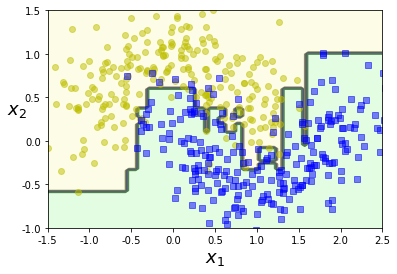

In [90]:
plot_decision_boundary(ada_clf, X, y)

## 5.2. 그래디언트 부스팅
* 아다부스트처럼 그래디언트 부스팅(Gradient Boosting)은 앙상블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가한다.
* 하지만 아다부스트처럼 반복마다 샘플의 가중치를 수정하는 대신 이전 예측기가 만든 잔여 **오차(residual error)**에 새로운 예측기를 학습시킨다.

* **그래디언트 트리 부스팅**(Gradient Tree Boosting) 또는 **그래디언트 부스티드 회귀 트리**(GBRT, Gradient Boosted Regression Tree) : 결정 트리를 기반 예측기로 사용하는 회귀(당연히 그래디언트 부스팅은 회귀 문제에도 아주 잘 작동한다)

### 5.2.1. 그래디언트 부스팅 과정 살펴보기
**1. 먼저 `DecisionTreeRegressor`를 훈련 세트(잡음이 섞인 2차 곡선 형태의 훈련 세트)에 학습**

In [92]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05*np.random.randn(100)

In [93]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

**2. 첫 번째 예측기에서 생긴 잔여 오차에 두 번째 `DecisionTreeRegressor` 훈련**

In [94]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

**3. 두 번째 예측기가 만든 잔여 오차에 세 번째 회귀 모델 훈련**

In [95]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

**4. 새로운 샘플에 대한 예측**  
세 개 트리를 포함하는 앙상블 모델로 새로운 샘플에 대한 예측을 만들려면 모든 트리의 예측을 더하면 된다.

In [96]:
X_new = np.array([[0.8]])

y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([0.75026781])

#### 예측 과정 살펴보기

In [102]:
def plot_predictions(regressors, X, y, axes, label=None, style='r-', data_style='b.',
                    data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc='upper center', fontsize=16)
    plt.axis(axes)

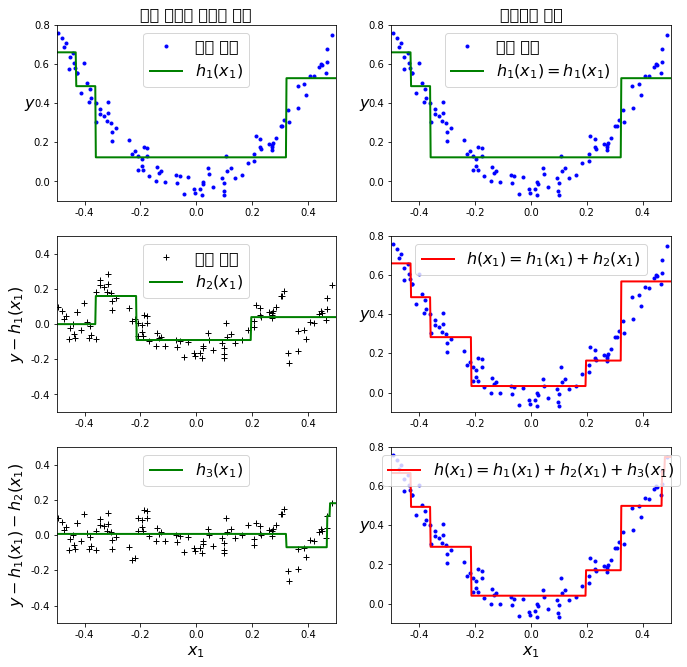

In [107]:
plt.figure(figsize=(11, 11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label='$h_1(x_1)$',
                style='g-', data_label='훈련 세트')
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.title('잔여 오차와 트리의 예측', fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], 
                 label='$h_1(x_1) = h_1(x_1)$', style='g-', data_label='훈련 세트')
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.title('앙상블의 예측', fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="잔여 오차")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

> * **열**
    * 왼쪽 열 : 이 세 트리의 예측
    * 오른쪽 열 : 앙상블의 예측
* **행**
    * 첫 번째 행 : 앙상블에 트리가 하나만 있어서 첫 번재 트리의 예측과 완전히 같다.
    * 두 번째 행 : 새로운 트리가 첫 번째 트리의 잔여 오차에 대해 학습되었다. 오른쪽의 앙상블 예측이 두 개의 트리 예측의 합과 같다.
    * 세 번째 행 : 또 다른 트리가 두 번째 트리의 잔여 오차에 훈련되었다.
* 트리가 앙상블에 추가될수록 앙상블의 예측이 점차 좋아지는 것을 알 수 있다.

`GradientBoostingRegressor`를 사용하면 GBRT 앙상블을 간단하게 훈련시킬 수 있다.
* 트리 수(`n_estimators`)와 같이 앙상블의 훈련을 제어하는 매개변수와 `RandomForestRegressor`와 아주 비슷하게 결정 트리의 성장을 제어하는 매개변수(`max_depth`, `min_samples_leaf` 등)를 가지고 있다.

#### 위에 만든 것과 같은 앙상블 만들기

In [108]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=0.1, 
                                random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=3, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

### 5.2.2. 규제
* `learning_rate` 매개변수가 각 트리의 기여 정도를 조절한다.

#### 축소(shrinkage)
* 규제 방법 중 하나
* `0.1`처럼 낮게 설정하면 앙상블을 훈련 세트에 학습시키기 위해 많은 트리가 필요하지만, 일반적으로 예측의 성능은 좋아진다.

#### 작은 학습률로 훈련시킨 두 개의 GBRT 앙상블

In [109]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

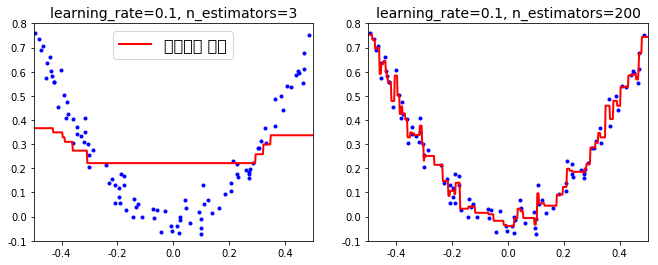

In [110]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="앙상블의 예측")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

plt.show()

> * **예측기가 부족한 경우의 GBRT 앙상블 (왼쪽)**
    * 훈련 세트를 학습하기에는 트리가 충분하지 않다.
* **예측기가 너무 많은 경우의 GBRT 앙상블 (오른쪽)**
    * 트리가 너무 많아 훈련 세트에 과대적합 되었다.

### 5.2.3. 최적의 트리 수 찾기
* 최적의 트리 수를 찾기 위해 조기 종료 기법(4장 참조)을 사용할 수 있다.
* 간단하게 구현하려면 `staged_predict()` 메서드를 사용한다.
    * 훈련의 각 단계(트리 하나, 트리 두 개 등)에서 앙상블에 의해 만들어진 예측기를 순회하는 반복자(iterator)를 반환한다.
    
#### 조기 종료를 사용한 그래디언트 부스팅
1. 120개 트리로 GBRT 앙상블을 훈련시키고 최적의 트리 수를 찾기 위해 각 훈련 단계에서 검증 오차를 측정한다.  
2. 마지막에 최적의 트리 수를 사용해 새로운 GBRT 앙상블을 훈련시킨다.

In [112]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators,
                                     random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=55, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [113]:
min_error = np.min(errors)

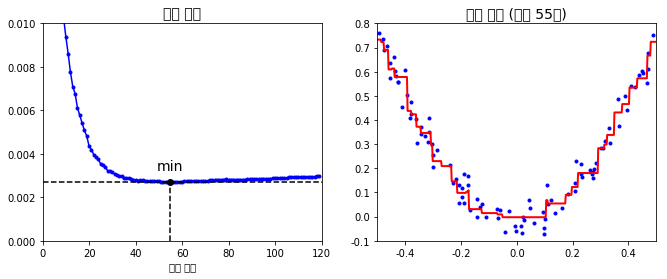

In [124]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, 'b.-')
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], 'k--')
plt.plot([0, 120], [min_error, min_error], 'k--')
plt.plot(bst_n_estimators, min_error, 'ko')
plt.text(bst_n_estimators, min_error*1.2, 'min', ha='center', fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel('트리 개수')
plt.title('검증 오차', fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title('최적 모델 (트리 %d개)' % bst_n_estimators, fontsize=14)

plt.show()

> **조기 종료를 사용하여 트리 수 튜닝**  
* **검증 오차 (왼쪽)**
* **최적 모델의 예측 (오른쪽**

#### 훈련을 중지하는 방법으로 조기 종료 구현
* (많은 수의 트리를 먼저 훈련시키고 최적의 수를 찾기 위해 살펴보는 대신) 실제로 훈련을 중지하는 방법으로 조기종료 구현할 수도 있다.
* `warm_start=True`로 설정하면 scikit-learn이 `fit()` 호출 시 기존 트리를 유지하고 훈련을 추가할 수 있도록 해준다.

#### 연속해서 다섯 번의 반복동안 검증 오차가 향상되지 않으면 훈련을 멈추는 코드

In [126]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float('inf')
error_going_up = 0

for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0 
    else:
        error_going_up += 1
        if error_going_up == 5:
            break

In [127]:
print(gbrt.n_estimators)
print('최소 검증 MSE:' , min_val_error)

61
최소 검증 MSE: 0.002712853325235463


#### 확률적 그래디언트 부스팅
* `subsample` 매개변수는 각 트리가 훈련할 때 사용할 훈련 샘플의 비율을 지정한다.
* ex)  
`subsample=0.25`는 각 트리는 무작위로 선택된 25%의 훈련 샘플로 학습된다.
* 편향이 높아지는 대신 분산이 낮아지게 되고 또한 훈련 속도를 상당히 높인다.
* 이런 기법을 **확률적 그래디언트 부스팅**(Stchastic Gradient Boosting)이라고 한다.

> **NOTE**  
* 그래디언트 부스팅에 다른 비용 함수를 사용할 수도 있다. 
* `loss` 매개변수로 지정
    * `GradientBoostingClassifier`의 `loss` 매개변수 옵션
        * `deviance`(기본값) : 로지스틱 손실 함수
        * `exponential` : 아다부스트에서 사용하는 옵션
    * `GradientBoostingRegressor`의 `loss` 매개변수 옵션
        * `ls`(기본값) : 최소제곱
        * `lad` : 최소 절댓값 오차
        * `huber` : 후버 손실 함수
        * `quantile` : 사분위수 손실 함수

## 5.3. XGBoost

In [130]:
try:
    import xgboost
except ImportError as ex:
    print("에러: xgboost 라이브러리가 설치되지 않았습니다.")
    xgboost = None

In [131]:
if xgboost is not None:  # 책에는 없음
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    print("검증 MSE:", val_error)

검증 MSE: 0.0028512559726563943


In [133]:
if xgboost is not None:  # 책에는 없음
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], early_stopping_rounds=2)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    print("검증 MSE:", val_error)

[0]	validation_0-rmse:0.286719
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.258221
[2]	validation_0-rmse:0.232634
[3]	validation_0-rmse:0.210526
[4]	validation_0-rmse:0.190232
[5]	validation_0-rmse:0.172196
[6]	validation_0-rmse:0.156394
[7]	validation_0-rmse:0.142241
[8]	validation_0-rmse:0.129789
[9]	validation_0-rmse:0.118752
[10]	validation_0-rmse:0.108388
[11]	validation_0-rmse:0.100155
[12]	validation_0-rmse:0.09208
[13]	validation_0-rmse:0.084791
[14]	validation_0-rmse:0.078699
[15]	validation_0-rmse:0.073248
[16]	validation_0-rmse:0.069391
[17]	validation_0-rmse:0.066277
[18]	validation_0-rmse:0.063458
[19]	validation_0-rmse:0.060326
[20]	validation_0-rmse:0.0578
[21]	validation_0-rmse:0.055643
[22]	validation_0-rmse:0.053943
[23]	validation_0-rmse:0.053138
[24]	validation_0-rmse:0.052415
[25]	validation_0-rmse:0.051821
[26]	validation_0-rmse:0.051226
[27]	validation_0-rmse:0.051135
[28]	validation_0-rmse:0.05091
[29]	validation_0-rmse

In [134]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None

6.03 ms ± 422 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [135]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

12.4 ms ± 122 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# 6. 스태킹
* 또 다른 앙상블 모델 **스태킹**(stacking, stacked generalization의 줄임말)은 '앙상블에 속한 모든 예측기의 예측을 취합하는 간단한 함수(직접 투표같은)를 사용하는 대신 취합하는 모델을 훈련시킬 수 없을까?'라는 기본 아이디어로 출발한다.
* 3개의 각 예측기가 새로운 샘플에 대한 회귀 결과로 각각 다른 값(3.1, 2.7, 2.9)을 예측하고 마지막 예측기(**블렌더**(blender) 또는 **메타 학습기**(meta learner)라고 한다)가  이 예측을 입력으로 받아 최종 예측(3.0)을 만든다.

## 6.1. 블렌더 학습 방법
* 블렌더를 학습시키는 일반적인 방법은 홀드 아웃(hold-out) 세트를 사용하는 것이다.
> * **스태킹** : 아웃 오브 폴드(out-of-fold) 예측을 사용하는 것
    * 아웃 오브 폴드 예측은 k-겹 교차 검증에서 검증 폴드의 결과를 모두 모은 것
    * `cross_val_predict()`를 사용하면 k-겹 교차 검증에서 각 폴드에 대한 예측값을 얻을 수 있다.
 * **블렌딩**(blending) : 홀드 아웃 세트를 사용하는 것
 * 많은 사람이 두 용어를 같은 의미로 사용한다.
 
#### 작동 과정
1. 먼저 훈련 세트를 두 개의 subset으로 나눈다.
    * 첫 번째 subset은 첫 번째 레이어의 예측을 훈련시키기 위해 사용된다.
    * 위 예에 맞게 3개의 예측기에 대해 훈련한다.
2. 첫 번째 레이어의 예측기를 사용해 두 번째 (홀드 아웃) 세트(두 번째 subset)에 대한 예측을 만든다.
    * 예측기들이 훈련하는 동안 이 샘플들을 전혀 보지 못했기 때문에 이 때 만들어진 예측은 완전히 새로운 것이다.
    * 이제 홀드 아웃 세트의 각 샘플에 대해 3개의 예측값이 만들어진다.
3. target값은 그대로 쓰고, 앞에서 예측한 값들을 입력 특성으로 사용하는 새로운 훈련 세트를 만들 수 있다.(새로운 훈련 세트는 3차원이 된다.)
    * 블렌더가 새 훈련 세트로 훈련된다. 즉, 첫 번째 레이어의 예측을 가지고 target값을 예측하도록 학습된다.

#### 멀티 레이어 스태킹 앙상블의 예측
* 이런 방식의 블렌더를 여러 개 훈련시키는 것도 가능하다.(ex. 하나는 선형 회귀로, 다른 하나는 랜덤 포레스트 회귀로, 등등) 그러면 블렌더만의 레이어가 만들어지게 된다.
* 이렇게 하려면 훈련 세트를 3개의 subset으로 나눈다.
    * 첫 번째 세트 : 첫 번째 레이어를 훈련시키는 사용
    * 두 번째 세트 : (첫 번째 레이어의 예측기로) 두 번째 레이어를 훈련시키기 위한 훈련 세트를 만드는 데 사용
    * 세 번째 세트 : (두 번째 레이어의 예측기로) 세 번째 레이어를 훈련시키기 위한 훈련 세트를 만드는 데 사용
* 작업이 끝나면 각 레이어를 차례대로 실행해서 새로운 샘플에 대한 예측을 만들 수 있다. (신경망 구조처럼 멀티 레이어를 가진)
* scikit-learn은 스태킹을 직접 지원하지 않는다. 하지만 직접 구현하는 것이 그리 어렵지 않다.

# 연습문제

## 1.
정확히 같은 훈련 데이터로 다섯 개의 다른 모델을 훈련시켜서 모두 95% 정확도를 얻었다면 이 모델들을 연결하여 더 좋은 결과를 얻을 수 있을까요? 가능하다면 어떻게 해야 할까요? 그렇지 않다면 왜 일까요?

이들을 연결하여 투표 앙상블(voting ensemble)을 만들어 더 나은 결과를 기대할 수 있다.  만약 모델이 서로 다르다면(예를 들면 SVM분류기, 결정 트리 분류기, 로지스틱 회귀 분류기 등) 훨씬 좋다.  
만약 다른 훈련 샘플에서 훈련되었다면 더더욱 좋다(이것이 배깅과 페이스팅 앙상블의 핵심이다).  
하지만 그렇지 않더라도 모델이 서로 많이 다르다면 여전히 좋은 결과를 낸다.

## 2.
직접 투표와 간접 투표 분류기 사이의 차이점은 무엇일까요?

* 직접 투표 분류기 : 앙상블에 있는 각 분류기의 선택을 count해서 가장 많은 투표를 얻은 클래스를 선택
* 간접 투표 분류기 : 각 클래스의 평균적인 확률 추정값을 계산해서 가장 높은 확률을 가진 클래스를 고른다.
    * 이 방식은 신뢰가 높은 투표에 더 가중치를 주고 종종 더 나은 성능을 낸다.
    * 하지만 앙상블에 있는 모든 분류기가 클래스 확률을 추정할 수 있어야 사용할 수 있다. (예를 들어 SVM분류기를 `probability=True`로 지정해야 한다)

## 3.
배깅 앙상블의 훈련을 여러 대의 서버에 분산시켜 속도를 높일 수 있을까요? 페이스팅 앙상블, 부스팅 앙상블, 랜덤 포레스트, 스태킹 앙상블의 경우는 어떨까요?

* 배깅 앙상블, 페이스팅 앙상블, 랜덤 포레스트 : 각 예측기는 독립적이므로 여러 대의 서버에 분산하여 앙상블의 훈련 속도를 높일 수 있다.
* 부스팅 앙상블 : 예측기가 이전 예측기 기반으로 만들어지므로 훈련이 순차적이어야 하고 여러 대의 서버에 분산해서 얻을 수 있는 이득이 없다.
* 스태킹 앙상블 : 한 층의 모든 예측기가 각각 독립적이르모 여러 대의 서버에서 병렬로 훈련될 수 있다.  
그러나 한 층에 있는 예측기들은 이전 층의 예측기들이 훈련된 후에 훈련될 수 있다.

## 4. 
oob 평가의 장점은 무엇인가요?

배깅 앙상블의 각 예측기가 훈련에 포함되지 않은 (즉, 따로 떼어놓은) 샘플을 사용해 평가된다.  
이는 추가적인 검증 세트가 없어도 편향되지 않게 앙상블을 평가하도록 도와준다.
그러므로 훈련에 더 많은 샘플을 사용할 수 있어서 앙상블의 성능은 조금 더 향상될 것이다.

## 5.
무엇이 엑스트라 트리를 일반 랜덤 포레스트보다 더 무작위하게 만드나요? 추가적인 무작위성이 어떻게 도움이 될까요? 엑스트라 트리는 일반 랜덤 포레스트보다 느릴까요, 빠를까요?

랜덤 포레스트에서 트리가 성장할 때 각 노드에서 특성의 일부를 무작위로 선택해 분할에 사용한다. 엑스트라 트리도 이는 마찬가지지만 한 단계 더 나아가서 일반 결정 트리처럼 가능한 최선의 임계점을 찾는 것이 아니라 각 특성에 대해 랜덤한 임계점을 사용한다.  
이 추가적인 무작위성은 규제처럼 작동한다. 즉, 랜덤 포레스트가 훈련 데이터에 과대적합되었다면 엑스트라 트리는 그렇지 않을 것이다.  
또한 엑스트라 트리는 가능한 최선의 임계점을 찾지 않기 때문에 랜덤 포레스트보다 훨씬 빠르게 훈련된다.  
그러나 예측을 할 때는 랜덤 포레스트보다 더 빠르지도 느리지도 않다.

## 6.
아다부스트 앙상블이 훈련 데이터에 과소적합되었다면 어떤 매개변수를 어떻게 바꾸어야 할까요?

예측기 수를 증가시키거나 기반 예측기의 규제 하이퍼파라미터를 감소시켜 볼 수 있다.  
또한 학습률을 약간 증가시켜 볼 수 있다.

## 7.
그래디언트 부스팅 앙상블이 훈련 데이터에 과대적합되었다면 학습률을 높여야 할까요, 낮춰야 할까요?

학습률을 감소시켜야 한다. (예측기 수가 너무 많으면) 알맞은 개수를 찾기 위해 조기 종료 기법을 사용할 수 있다.

## 8.
(3장에서 소개한) MNIST 데이터를 불러들여 훈련 세트, 검증 세트, 테스트 세트로 나눕니다(예를 들면 훈련에 40,000개 샘플, 검증에 10,000개 샘플, 테스트에 10,000개 샘플). 그런 다음 랜덤 포레스트 분류기, 엑스트라 트리 분류기, SVM 같은 여러 종류의 분류기를 훈련시킵니다. 그리고 검증 세트에서 개개의 분류기보다 더 높은 성능을 내도록 이들을 간접 또는 직접 투표 분류기를 사용하는 앙상블로 연결해보세요. 앙상블을 얻고 나면 테스트 세트로 확인해보세요. 개개의 분류기와 비교해서 성능이 얼마나 향상되나요?

In [136]:
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original')

# from sklearn.datasets import fetch_openml
# mnist = fetch_openml('mnist_784', version=1)

C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


In [138]:
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(mnist.data, mnist.target,
                                        test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                        test_size=10000, random_state=42)

문제: 그런 다음 랜덤 포레스트 분류기, 엑스트라 트리 분류기, SVM 같은 여러 종류의 분류기를 훈련시킵니다.

In [139]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

random_forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=10, random_state=42)
svm_clf = LinearSVC(max_iter=10000, random_state=42)
mlp_clf = MLPClassifier(random_state=42)

In [140]:
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]

for estimator in estimators:
    print("훈련 예측기: ", estimator)
    estimator.fit(X_train, y_train)

훈련 예측기:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
훈련 예측기:  ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)
훈련 예측기:  LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=10000,
     multi_class='ovr', pena

C:\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


훈련 예측기:  MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=42, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)


In [141]:
[estimator.score(X_val, y_val) for estimator in estimators]

[0.9467, 0.9512, 0.8648, 0.9619]

> 선형 SVM이 다른 분류기보다 성능이 많이 떨어진다. 그러나 투표 기반 분류기의 성능을 향상시킬 수 있으므로 그대로 둔다.

문제: 그리고 검증 세트에서 개개의 분류기보다 더 높은 성능을 내도록 이들을 간접 또는 직접 투표 분류기를 사용하는 앙상블로 연결해보세요.

In [142]:
from sklearn.ensemble import VotingClassifier

named_estimators = [
    ('random_forest_clf', random_forest_clf),
    ('extra_trees_clf', extra_trees_clf),
    ('svm_clf', svm_clf),
    ('mlp_clf', mlp_clf)
]
voting_clf = VotingClassifier(named_estimators)
voting_clf.fit(X_train, y_train)

C:\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


VotingClassifier(estimators=[('random_forest_clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
   ...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

In [143]:
voting_clf.score(X_val, y_val)

0.9633

In [145]:
[estimator.score(X_val, y_val) for estimator in voting_clf.estimators_]

[0.9467, 0.9512, 0.8648, 0.9619]

SVM 모델 제거해서 성능 향상되는지 확인하기

In [146]:
voting_clf.set_params(svm_clf=None)

VotingClassifier(estimators=[('random_forest_clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
   ...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

예측기 목록이 업데이되었다.

In [147]:
voting_clf.estimators

[('random_forest_clf',
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=None, max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
              oob_score=False, random_state=42, verbose=0, warm_start=False)),
 ('extra_trees_clf',
  ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
             oob_score=False, random_state=42, verbose=0, warm_start=False)),
 ('svm_clf', None),
 ('mlp_clf',
  MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
 

하지만 훈련된 예측기 목록은 업데이트 되지 않는다.

In [148]:
voting_clf.estimators_

[RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
             oob_score=False, random_state=42, verbose=0, warm_start=False),
 ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
 LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=10000,
      multi_class='ovr', penalty='l2', 

`VotingClassifier`를 다시 훈련시키거나, 그냥 훈련된 예측기 목록에서 SVM 모델을 제거할 수 있다.

In [149]:
del voting_clf.estimators_[2]

`VotingClassifier` 다시 평가하기

In [150]:
voting_clf.score(X_val, y_val)

0.9677

> 훨씬 좋아졌다. SVM 모델이 성능을 저하시켰다.

이제 간접 투표 분류기 사용해보기  
분류기를 다시 훈련시킬 필요는 없고 `voting`을 'soft'로 지정하면 된다.

In [151]:
voting_clf.voting = 'soft'

In [152]:
voting_clf.score(X_val, y_val)

0.971

> 성능이 많이 나아지고 개개의 분류기보다 훨씬 좋다.

문제: 앙상블을 얻고 나면 테스트 세트로 확인해보세요. 개개의 분류기와 비교해서 성능이 얼마나 향상되나요?

In [154]:
voting_clf.score(X_test, y_test)

0.9685

In [155]:
[estimator.score(X_test, y_test) for estimator in voting_clf.estimators_]

[0.9434, 0.9444, 0.9602]

> 투표 기반 분류기는 에러율을 제일 좋은 모델(`MLPClassifier`)의 4.9%에서 3.5%로 줄였다.  
약 28%나 오류가 적다. 나쁘지 않다.

## 9.
이전 연습문제의 각 분류기를 실행해서 검증 세트에서 예측을 만들고 그 결과로 새로운 훈련 세트를 만들어보세요. 각 훈련 샘플은 하나의 이미지에 대한 전체 분류기의 예측을 담은 벡터고 타깃은 이미지의 클래스입니다. 새로운 훈련 세트에 분류기 하나를 훈련시켜보세요. 방금 블렌더를 훈련시켰습니다. 그리고 이 분류기를 모아서 스태킹 앙상블을 구성했습니다. 이제 테스트 세트에 앙상블을 평가해보세요. 테스트 세트의 각 이미지에 대해 모든 분류기로 예측을 만들고 앙상블의 예측 결과를 만들기 위해 블렌더에 그 예측을 주입합니다. 앞서 만든 투표 분류기와 비교하면 어떤가요?

In [157]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)
    
X_val_predictions

array([[2., 2., 2., 2.],
       [7., 7., 7., 7.],
       [4., 4., 4., 4.],
       ...,
       [4., 4., 4., 4.],
       [9., 9., 9., 9.],
       [4., 4., 4., 4.]], dtype=float32)

In [158]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, 
                                           random_state=42)
rnd_forest_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

In [159]:
rnd_forest_blender.oob_score_

0.967

> 이 블렌더를 세밀하게 튜닝하거나 다른 종류의 블렌더(예를 들어 `MLPClassifier`)를 시도해 볼 수 있다.  
늘 하던대로 다음 교차 검증을 사용해 가장 좋은 것을 선택한다.

문제: 축하합니다. 방금 블렌더를 훈련시켰습니다. 그리고 이 분류기를 모아서 스태킹 앙상블을 구성했습니다. 이제 테스트 세트에 앙상블을 평가해보세요. 테스트 세트의 각 이미지에 대해 모든 분류기로 예측을 만들고 앙상블의 예측 결과를 만들기 위해 블렌더에 그 예측을 주입합니다. 앞서 만든 투표 분류기와 비교하면 어떤가요?

In [160]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)
    
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [161]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.9611

> 앞서 만든 간접 투표 분류기만큼 성능을 내지는 못한다.  
하지만 개개의 분류기보다는 당연히 좋다.